In [1]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

-----
## DB에 데이터 적재

In [8]:
#클라우드 DB - postgresql
import psycopg2

conn = psycopg2.connect(
    host = 'peanut.db.elephantsql.com',
    database = 'dwsiqwgs',
    user = 'dwsiqwgs',
    password = 'QfY7jVWTDpPoUzikHE8QonmdXrdj67IV'
)
cur = conn.cursor()

In [2]:
# 로컬 DB - SQLite
import sqlite3
conn = sqlite3.connect('data.db')
cur = conn.cursor()

In [3]:
cur.execute("DROP TABLE IF EXISTS Customer;")
cur.execute('''CREATE TABLE Customer(
    Id integer primary key,
    Gender text,
    MaritalStatus text,
    CityTier integer,
    Tenure integer,
    Churn integer,
    PreferredLoginDevice text,
    PreferredPaymentMode text,
    HourSpendOnApp integer,
    PreferredOrderCat text,
    OrderIncrease integer,
    CouponUsed integer,
    OrderCount integer,
    DaySinceLastOrder integer,
    SatisfactionScore integer,
    Complain integer);
    ''')

conn.commit()

In [4]:
raw = pd.read_csv('raw.csv')
print(raw.shape)
raw.head()

(4025, 16)


,Id,Churn,Tenure,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,HourSpendOnApp,PreferredOrderCat,SatisfactionScore,MaritalStatus,Complain,OrderIncrease,CouponUsed,OrderCount,DaySinceLastOrder
0,1,1,4.0,Mobile Phone,3,Debit Card,Female,3,Laptop & Accessory,2,Single,1,11.0,1.0,1.0,5.0
1,2,1,0.0,Phone,3,Debit Card,Male,2,Laptop & Accessory,5,Single,0,23.0,0.0,1.0,3.0
2,3,1,0.0,Computer,1,Debit Card,Female,3,Mobile Phone,5,Single,1,22.0,4.0,6.0,7.0
3,4,1,11.0,Mobile Phone,1,Debit Card,Male,3,Fashion,3,Single,1,13.0,0.0,1.0,0.0
4,5,1,0.0,Phone,1,Cash on Delivery,Male,2,Mobile,3,Single,1,13.0,2.0,2.0,2.0


In [5]:
raw = raw.astype({'Tenure': int, 'OrderIncrease':int, 'CouponUsed':int, 'OrderCount':int, 'DaySinceLastOrder':int})

In [6]:
# raw 데이터 컬렴명 순서 정렬
raw = raw[['Id','Gender','MaritalStatus','CityTier','Tenure','Churn','PreferredLoginDevice','PreferredPaymentMode','HourSpendOnApp','PreferredOrderCat','OrderIncrease','CouponUsed','OrderCount','DaySinceLastOrder','SatisfactionScore','Complain']]

In [7]:
# db 적재용(전처리만 끝낸 데이터)
raw.to_csv('raw_data.csv', index=False)

In [8]:
# df 각 행을 튜플로
def make_tuple(df, num):
    data_lst = []
    val = tuple(df.iloc[num])
    return val

val_lst = []
for i in range(0, len(raw)):
    val = make_tuple(raw, i)
    val_lst.append(val)

In [9]:
# DB에 데이터 적재
cols = tuple(raw.columns)

for val in val_lst:
    cur.execute(f"INSERT INTO Customer VALUES {val};")

conn.commit()

----
## DB에서 데이터 불러오기

In [10]:
# 전체 불러오기
cur.execute('SELECT * FROM Customer')
data = cur.fetchall()

In [11]:
df = pd.DataFrame(data, columns=['Id','Gender','MaritalStatus','CityTier','Tenure','Churn','PreferredLoginDevice','PreferredPaymentMode','HourSpendOnApp','PreferredOrderCat','OrderIncrease','CouponUsed','OrderCount','DaySinceLastOrder','SatisfactionScore','Complain'])
print(df.shape)
df.head()

(4025, 16)


,Id,Gender,MaritalStatus,CityTier,Tenure,Churn,PreferredLoginDevice,PreferredPaymentMode,HourSpendOnApp,PreferredOrderCat,OrderIncrease,CouponUsed,OrderCount,DaySinceLastOrder,SatisfactionScore,Complain
0,1,Female,Single,3,4,1,Mobile Phone,Debit Card,3,Laptop & Accessory,11,1,1,5,2,1
1,2,Male,Single,3,0,1,Phone,Debit Card,2,Laptop & Accessory,23,0,1,3,5,0
2,3,Female,Single,1,0,1,Computer,Debit Card,3,Mobile Phone,22,4,6,7,5,1
3,4,Male,Single,1,11,1,Mobile Phone,Debit Card,3,Fashion,13,0,1,0,3,1
4,5,Male,Single,1,0,1,Phone,Cash on Delivery,2,Mobile,13,2,2,2,3,1


------
### 클러스터링    
- 기존 고객 대상으로 2개 그룹으로 나눠 특징 살펴보자

In [12]:
# dfc : 클러스터링용 데이터셋(이탈 고객 제외, 기존고객 대상)
c = df.copy() 
ck = c[c.Churn==0] #기존 고객만, 이탈고객도 포함하니 구분 제대로 안 됨
ck.head()

,Id,Gender,MaritalStatus,CityTier,Tenure,Churn,PreferredLoginDevice,PreferredPaymentMode,HourSpendOnApp,PreferredOrderCat,OrderIncrease,CouponUsed,OrderCount,DaySinceLastOrder,SatisfactionScore,Complain
15,16,Male,Divorced,3,8,0,Mobile Phone,E wallet,3,Fashion,13,1,1,6,4,0
16,17,Male,Married,1,18,0,Phone,Debit Card,2,Laptop & Accessory,18,1,1,15,4,0
17,18,Female,Single,3,5,0,Computer,E wallet,2,Fashion,14,2,3,7,2,0
18,19,Male,Divorced,1,2,0,Computer,Cash on Delivery,2,Laptop & Accessory,13,0,1,9,3,0
19,20,Male,Divorced,1,0,0,Mobile Phone,Credit Card,2,Laptop & Accessory,17,1,1,0,3,0


- 기존 유저를 활동유저와 비활동유저로 구분   
- 구분 기준 : 앱 체류시간, 주문건수, 만족도 등


In [13]:
# cl_c = cl[[
#     'Id',
#     'Tenure', # 연속형
#     'HourSpendOnApp', # 연속형
#     'SatisfactionScore', # 범주형(순서형)
#     'Complain', # 범주형
#     'OrderIncrease', # 연속형
#     'OrderCount', # 연속형
#     'DaySinceLastOrder']] # 연속형
ck_c = ck[['Id','Tenure','OrderCount']]

ck_c.set_index(keys=['Id'], inplace=True, drop=True)
ck_c.head()

,Tenure,OrderCount
Id,,
16,8,1
17,18,1
18,5,3
19,2,1
20,0,1


In [14]:
# log transformation 위해 0 처리
# Tenure : 1개월 미만 → 0.5로 처리
# DaySinceLastOrder : 1일 이내 → 0.5로 처리
# HourSpendOnApp : 1시간 미만 → 0.5로 처리
ck_cz = ck_c.replace({0:0.5})
ck_cz.describe()

,Tenure,OrderCount
count,3310.000000,3310.000000
mean,9.862689,2.776435
std,7.549151,2.467349
min,0.500000,1.000000
25%,4.000000,1.000000
50%,9.000000,2.000000
75%,14.000000,3.000000
max,51.000000,16.000000


In [15]:
# log transformation
col1 = np.log(ck_cz.Tenure)
# col2 = np.log(ck_cz.HourSpendOnApp)
# col3 = np.log(ck_cz.OrderIncrease)
col4 = np.log(ck_cz.OrderCount)
# col5 = np.log(ck_cz.DaySinceLastOrder)

ck_log = pd.concat([col1, col4], axis=1)
ck_log.head()


,Tenure,OrderCount
Id,,
16,2.079442,0.000000
17,2.890372,0.000000
18,1.609438,1.098612
19,0.693147,0.000000
20,-0.693147,0.000000


In [16]:
# scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ck_scaled = scaler.fit_transform(ck_log)
print('mean: ', ck_scaled.mean(axis=0).round(2))
print('std: ', ck_scaled.std(axis=0).round(2))

mean:  [ 0. -0.]
std:  [1. 1.]


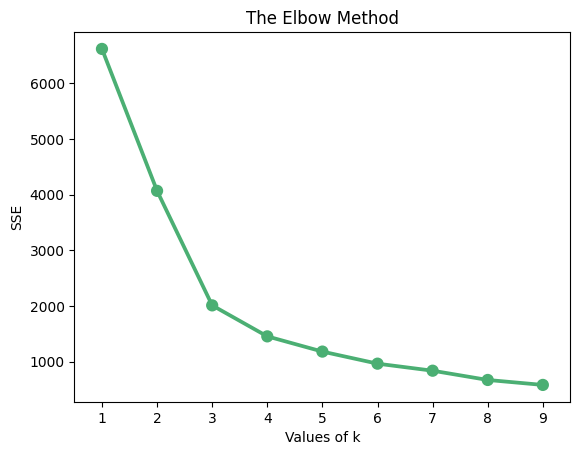

In [17]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(ck_scaled)
    sse[k] = kmeans.inertia_

plt.title('The Elbow Method')
plt.xlabel('Values of k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()), color='#4BAF73')
plt.show()

In [18]:
# 최종 모델 학습
kmeans = KMeans(n_clusters=3, max_iter=50, random_state=42)
kmeans.fit(ck_scaled)

# 고객별 클러스터 지정
cluster_labels = kmeans.labels_

ck3 = ck.assign(Cluster = cluster_labels)
ck3.head()

,Id,Gender,MaritalStatus,CityTier,Tenure,Churn,PreferredLoginDevice,PreferredPaymentMode,HourSpendOnApp,PreferredOrderCat,OrderIncrease,CouponUsed,OrderCount,DaySinceLastOrder,SatisfactionScore,Complain,Cluster
15,16,Male,Divorced,3,8,0,Mobile Phone,E wallet,3,Fashion,13,1,1,6,4,0,0
16,17,Male,Married,1,18,0,Phone,Debit Card,2,Laptop & Accessory,18,1,1,15,4,0,0
17,18,Female,Single,3,5,0,Computer,E wallet,2,Fashion,14,2,3,7,2,0,0
18,19,Male,Divorced,1,2,0,Computer,Cash on Delivery,2,Laptop & Accessory,13,0,1,9,3,0,1
19,20,Male,Divorced,1,0,0,Mobile Phone,Credit Card,2,Laptop & Accessory,17,1,1,0,3,0,1


In [19]:
# 클러스터별 특징 분석
c_avg_num = ck3.groupby(['Cluster']).mean()
c_avg_num

C:\Users\MSI\AppData\Local\Temp\ipykernel_15812\1390891213.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  c_avg_num = ck3.groupby(['Cluster']).mean()


,Id,CityTier,Tenure,Churn,HourSpendOnApp,OrderIncrease,CouponUsed,OrderCount,DaySinceLastOrder,SatisfactionScore,Complain
Cluster,,,,,,,,,,,
0,2002.406397,1.631358,12.657053,0.0,2.909806,15.685370,1.136864,1.695333,3.973781,2.959098,0.249082
1,2039.896138,1.648469,1.264980,0.0,2.968043,15.858855,1.190413,1.845539,3.644474,3.023968,0.191744
2,2000.366564,1.757669,11.450920,0.0,2.983129,15.638037,3.808282,7.010736,7.728528,3.055215,0.231595


In [20]:
ck3.head()

,Id,Gender,MaritalStatus,CityTier,Tenure,Churn,PreferredLoginDevice,PreferredPaymentMode,HourSpendOnApp,PreferredOrderCat,OrderIncrease,CouponUsed,OrderCount,DaySinceLastOrder,SatisfactionScore,Complain,Cluster
15,16,Male,Divorced,3,8,0,Mobile Phone,E wallet,3,Fashion,13,1,1,6,4,0,0
16,17,Male,Married,1,18,0,Phone,Debit Card,2,Laptop & Accessory,18,1,1,15,4,0,0
17,18,Female,Single,3,5,0,Computer,E wallet,2,Fashion,14,2,3,7,2,0,0
18,19,Male,Divorced,1,2,0,Computer,Cash on Delivery,2,Laptop & Accessory,13,0,1,9,3,0,1
19,20,Male,Divorced,1,0,0,Mobile Phone,Credit Card,2,Laptop & Accessory,17,1,1,0,3,0,1


In [21]:
# 그래프용 데이터
g = ck3[['Tenure', 'OrderCount', 'Cluster']]
g.Cluster.replace({0:'Non-active', 1:'New', 2:'Active'}, inplace=True)
g.head()

C:\Users\MSI\AppData\Local\Temp\ipykernel_15812\372262905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g.Cluster.replace({0:'Non-active', 1:'New', 2:'Active'}, inplace=True)


,Tenure,OrderCount,Cluster
15,8,1,Non-active
16,18,1,Non-active
17,5,3,Non-active
18,2,1,New
19,0,1,New


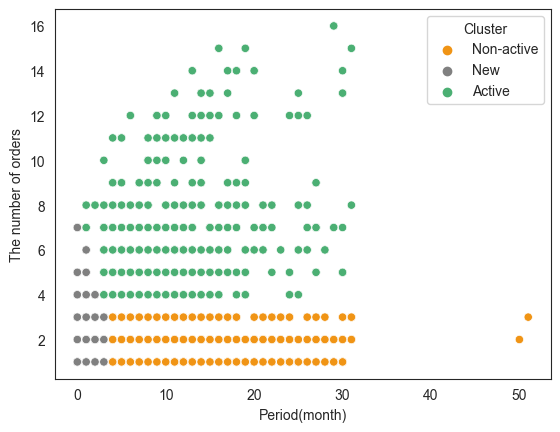

In [22]:
# 팔레트 설정
colors = ['#F09415', 'grey', '#4BAF73']
sns.set_palette(sns.color_palette(colors))

sns.set_style('white')
sns.scatterplot(data=g, x='Tenure', y='OrderCount', hue='Cluster', palette=colors)

plt.xlabel('Period(month)')
plt.ylabel('The number of orders')

plt.show();

- 0 : 가입 한지는 오래되었으나 구매빈도 적음 → 휴면고객, 구매유도   
- 1 : 특정 물건 사기 위해 가입, 불만제기 최저 → 다음 구매 유도해야
- 2 : 활동유저 - 이용기간 11.5개월, 쿠폰 사용과 주문건수 최다

In [23]:
ck3.Cluster.replace({0:1, 1:2, 2:3}, inplace=True)
ck3.head()

,Id,Gender,MaritalStatus,CityTier,Tenure,Churn,PreferredLoginDevice,PreferredPaymentMode,HourSpendOnApp,PreferredOrderCat,OrderIncrease,CouponUsed,OrderCount,DaySinceLastOrder,SatisfactionScore,Complain,Cluster
15,16,Male,Divorced,3,8,0,Mobile Phone,E wallet,3,Fashion,13,1,1,6,4,0,1
16,17,Male,Married,1,18,0,Phone,Debit Card,2,Laptop & Accessory,18,1,1,15,4,0,1
17,18,Female,Single,3,5,0,Computer,E wallet,2,Fashion,14,2,3,7,2,0,1
18,19,Male,Divorced,1,2,0,Computer,Cash on Delivery,2,Laptop & Accessory,13,0,1,9,3,0,2
19,20,Male,Divorced,1,0,0,Mobile Phone,Credit Card,2,Laptop & Accessory,17,1,1,0,3,0,2


In [24]:
ck3.Cluster.value_counts()

1    1907
2     751
3     652
Name: Cluster, dtype: int64

In [25]:
# df에 클러스터 추가
df['Cluster'] = 0
df.iloc[ck3.index] = ck3

In [26]:
# DB에 Cluster 컬럼 추가
cur.execute('ALTER TABLE Customer ADD Cluster int;')

# cluster 튜플 변환
cluster_val = tuple(df.Cluster)

# Cluster 컬럼에 값 ㅈ추가
for i in range(0, len(cluster_val)):
    cur.execute(f'UPDATE Customer SET Cluster = {cluster_val[i]} WHERE Id = {i+1};')
conn.commit()

------
## 모델링

In [29]:
# 라이브러리
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

In [30]:
# Id 제거 / dfm : 모델링용 데이터셋
dfm = df.drop(columns=['Id', 'Cluster']) # cluster 포함되면 모델 성능 떨어짐
print(dfm.shape)
dfm.head()

(4025, 15)


,Gender,MaritalStatus,CityTier,Tenure,Churn,PreferredLoginDevice,PreferredPaymentMode,HourSpendOnApp,PreferredOrderCat,OrderIncrease,CouponUsed,OrderCount,DaySinceLastOrder,SatisfactionScore,Complain
0,Female,Single,3,4,1,Mobile Phone,Debit Card,3,Laptop & Accessory,11,1,1,5,2,1
1,Male,Single,3,0,1,Phone,Debit Card,2,Laptop & Accessory,23,0,1,3,5,0
2,Female,Single,1,0,1,Computer,Debit Card,3,Mobile Phone,22,4,6,7,5,1
3,Male,Single,1,11,1,Mobile Phone,Debit Card,3,Fashion,13,0,1,0,3,1
4,Male,Single,1,0,1,Phone,Cash on Delivery,2,Mobile,13,2,2,2,3,1


In [31]:
# 훈련/검증/테스트 데이터 구분
train, test = train_test_split(
    dfm, train_size=0.80, test_size=0.20, stratify=dfm['Churn'], random_state=42)
train.shape, test.shape

((3220, 15), (805, 15))

In [32]:
target = 'Churn'

def divide_data(df):
    features = df.drop(columns=[target]).columns
    X = df[features]
    y = df[target]
    return X, y

X_train, y_train = divide_data(train)
X_test, y_test = divide_data(test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3220, 14) (3220,) (805, 14) (805,)


In [33]:
# 기준모델 - 최빈값
y_base = [y_train.mode()]*len(y_train)

# 기준모델 정확도
print("training accuracy: ", accuracy_score(y_train, y_base).round(2))

training accuracy:  0.82


In [34]:
dfm.head()

,Gender,MaritalStatus,CityTier,Tenure,Churn,PreferredLoginDevice,PreferredPaymentMode,HourSpendOnApp,PreferredOrderCat,OrderIncrease,CouponUsed,OrderCount,DaySinceLastOrder,SatisfactionScore,Complain
0,Female,Single,3,4,1,Mobile Phone,Debit Card,3,Laptop & Accessory,11,1,1,5,2,1
1,Male,Single,3,0,1,Phone,Debit Card,2,Laptop & Accessory,23,0,1,3,5,0
2,Female,Single,1,0,1,Computer,Debit Card,3,Mobile Phone,22,4,6,7,5,1
3,Male,Single,1,11,1,Mobile Phone,Debit Card,3,Fashion,13,0,1,0,3,1
4,Male,Single,1,0,1,Phone,Cash on Delivery,2,Mobile,13,2,2,2,3,1


xgboost 훈련 정확도 0.9990683229813665
xgboost 테스트 정확도 0.9701863354037267
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       662
           1       0.92      0.92      0.92       143

    accuracy                           0.97       805
   macro avg       0.95      0.95      0.95       805
weighted avg       0.97      0.97      0.97       805



c:\Users\MSI\anaconda3\envs\pj3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


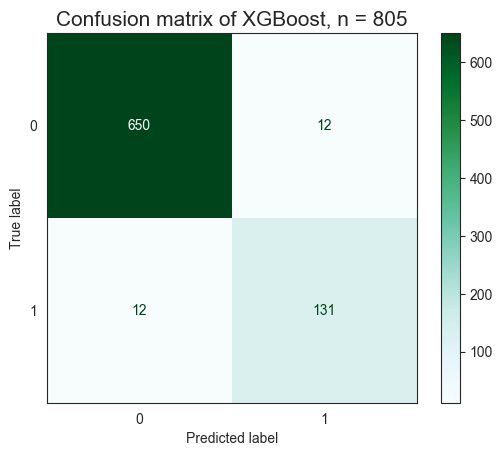

In [35]:
pipe_xgb = make_pipeline(
        OrdinalEncoder(),
        XGBClassifier(scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum())
        )

pipe_xgb.fit(X_train, y_train)
y_pred = pipe_xgb.predict(X_test)

print("xgboost 훈련 정확도", pipe_xgb.score(X_train, y_train))
print("xgboost 테스트 정확도", pipe_xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_xgb, X_test, y_test, cmap=plt.cm.BuGn, ax=ax)
plt.title(f'Confusion matrix of XGBoost, n = {len(y_test)}', fontsize=15)
plt.show();

Text(0.5, 1.0, 'Permutation Importance')

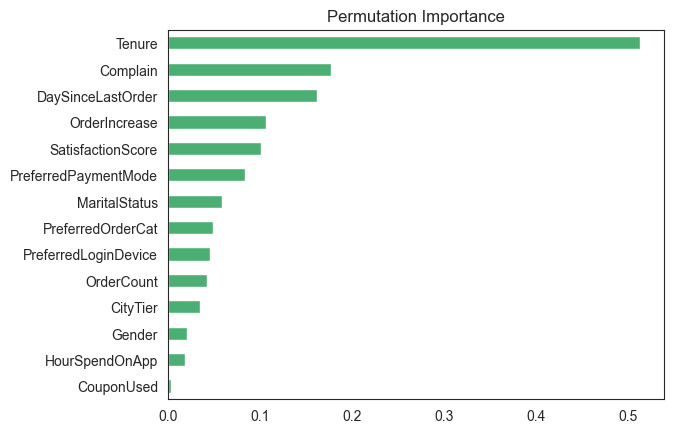

In [36]:
# permutation(순열중요도)
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe_xgb.named_steps["xgbclassifier"],  # model
    scoring="f1",  # metric
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=42,
)

# 스코어를 다시 계산합니다.
X_test_preprocessed = pipe_xgb[0].transform(X_test)
permuter.fit(X_test_preprocessed, y_test)

feature_names = X_test.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh(color='#4BAF73')
plt.title("Permutation Importance")

앱 구현 위해 특성 줄여 모델 재학습

In [37]:
dfm_n = dfm[['Churn','Tenure','Complain','DaySinceLastOrder','SatisfactionScore','HourSpendOnApp']] # permutation top5

dfm_n.head()

,Churn,Tenure,Complain,DaySinceLastOrder,SatisfactionScore,HourSpendOnApp
0,1,4,1,5,2,3
1,1,0,0,3,5,2
2,1,0,1,7,5,3
3,1,11,1,0,3,3
4,1,0,1,2,3,2


In [38]:
# 훈련/검증/테스트 데이터 구분
train_n, test_n = train_test_split(
    dfm_n, train_size=0.80, test_size=0.20, stratify=dfm['Churn'], random_state=42)

X_train_n, y_train_n = divide_data(train_n)
X_test_n, y_test_n = divide_data(test_n)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# 범주형 없으므로 ordinal 인코딩 제외
model = XGBClassifier(scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum())
model.fit(X_train_n, y_train_n)
y_pred_n = model.predict(X_test_n)

print("xgboost 훈련 정확도", model.score(X_train_n, y_train_n))
print("xgboost 테스트 정확도", model.score(X_test_n, y_test_n))
print(classification_report(y_test_n, y_pred_n))

(3220, 14) (3220,) (805, 14) (805,)
xgboost 훈련 정확도 0.915527950310559
xgboost 테스트 정확도 0.8770186335403727
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       662
           1       0.60      0.89      0.72       143

    accuracy                           0.88       805
   macro avg       0.79      0.88      0.82       805
weighted avg       0.91      0.88      0.89       805



In [39]:
# 피클링
import pickle
with open('model.pkl','wb') as pickle_file:
        pickle.dump(model, pickle_file)

In [40]:
# 예측결과 데이터셋에 추가
x = df[['Tenure','Complain','DaySinceLastOrder','SatisfactionScore','HourSpendOnApp']]
y = model.predict(x)

df['Churn_pred'] = y

In [41]:
# 예측결과 DB 적재
# DB에 Churn_pred 컬럼 추가
cur.execute('ALTER TABLE Customer ADD Churn_pred int;')

# cluster_pred 튜플 변환
pred_val = tuple(y)

# Cluster 컬럼에 값 ㅈ추가
for i in range(0, len(y)):
    cur.execute(f'UPDATE Customer SET Churn_pred = {pred_val[i]} WHERE Id = {i+1};')
conn.commit()

In [42]:
# db 적재용 csv 파일(클러스터 에측값 포함)
df.to_csv('db_data.csv', index=False)

In [45]:
# 대시보드 제작용 DB csv 파일
dash_data = df.copy()
dash_data.Cluster.replace({0:'이탈고객', 1:'휴면고객', 2:'신규고객', 3:'활동고객'}, inplace=True)
dash_data['Churn_pred'].replace({0:'유지', 1:'이탈예정'}, inplace=True)
dash_data['Gender'].replace({'Male':'남', 'Female':'여'}, inplace=True)
dash_data['MaritalStatus'].replace({'Single':'미혼', 'Married':'기혼', 'Divorced':'이혼'}, inplace=True)
dash_data.to_csv('dash_data.csv', index=False)